In [91]:
from data import YourNameImageDataset
from torch.utils.data import DataLoader
import torchvision.transforms as tfs
import PIL.Image
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import math
import sepconv
import tqdm
import glob
import random
import os.path as osp
from IPython.display import display, Image

In [2]:
toTensor = tfs.ToTensor()
toPILImage = tfs.ToPILImage()

def load_image(filename):
    return toTensor(PIL.Image.open(filename).convert('RGB'))

In [3]:
filenames = glob.glob('../../project/data/png/142p/*.png')
filenames.sort()

In [4]:
def get_dataset_filenames(filenames, indexes):
    res = []
    for index in indexes:
        res.append(filenames[index*3])
        res.append(filenames[index*3+1])
        res.append(filenames[index*3+2])
    return res

In [5]:
indexes = list(range((len(filenames)-1) // 3))
random.shuffle(indexes)
train_indexes = indexes[0: 45000]
val_indexes = indexes[45000: 50000]
test_indexes = indexes[50000:]
train_filenames = sorted(get_dataset_filenames(filenames, train_indexes))
val_filenames = sorted(get_dataset_filenames(filenames, val_indexes))
test_filenames = sorted(get_dataset_filenames(filenames, test_indexes))

In [6]:
train_yourname_dataset = YourNameImageDataset('../../project/data/png/142p/', filenames=train_filenames)
val_yourname_dataset = YourNameImageDataset('../../project/data/png/142p/', filenames=val_filenames)
test_yourname_dataset = YourNameImageDataset('../../project/data/png/142p/', filenames=test_filenames)

In [7]:
train_yourname_dataloader = DataLoader(train_yourname_dataset, batch_size = 4, shuffle=True, pin_memory=True, num_workers=4)
val_yourname_dataloader = DataLoader(val_yourname_dataset, batch_size = 16, shuffle=False, pin_memory=True, num_workers=4)
test_yourname_dataloader = DataLoader(test_yourname_dataset, batch_size = 16, shuffle=False, pin_memory=True, num_workers=4)

In [8]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        def ConvLayer(in_channels, out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False)
            )
        # end

        def Upsample(in_channels, out_channels):
            return torch.nn.Sequential(
                torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False)
            )
        # end

        def Subnet():
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(in_channels=64, out_channels=51, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                torch.nn.Conv2d(in_channels=51, out_channels=51, kernel_size=3, stride=1, padding=1)
            )
        # end

        self.netConv1 = ConvLayer(6, 32)
        self.netConv2 = ConvLayer(32, 64)
        self.netConv3 = ConvLayer(64, 128)
        self.netConv4 = ConvLayer(128, 256)
        self.netConv5 = ConvLayer(256, 512)

        self.netDeconv5 = ConvLayer(512, 512)
        self.netDeconv4 = ConvLayer(512, 256)
        self.netDeconv3 = ConvLayer(256, 128)
        self.netDeconv2 = ConvLayer(128, 64)

        self.netUpsample5 = Upsample(512, 512)
        self.netUpsample4 = Upsample(256, 256)
        self.netUpsample3 = Upsample(128, 128)
        self.netUpsample2 = Upsample(64, 64)

        self.netVertical1 = Subnet()
        self.netVertical2 = Subnet()
        self.netHorizontal1 = Subnet()
        self.netHorizontal2 = Subnet()


    def forward(self, tenFirst, tenSecond):
        assert(tenFirst.size(2) == tenSecond.size(2))
        assert(tenFirst.size(3) == tenSecond.size(3))
#         print(tenFirst.shape, tenSecond.shape)
        height, width = tenFirst.size(2), tenFirst.size(3)
        pad_height = 0 if height % 32 == 0 else 32 - (height % 32)
        pad_width = 0 if width % 32 == 0 else 32 - (width % 32)
        
        tenFirst = F.pad(tenFirst, [0, pad_width, 0, pad_height])
        tenSecond = F.pad(tenSecond, [0, pad_width, 0, pad_height])

            
        tenConv1 = self.netConv1(torch.cat([ tenFirst, tenSecond ], 1))
        tenConv2 = self.netConv2(torch.nn.functional.avg_pool2d(input=tenConv1, kernel_size=2, stride=2, count_include_pad=False))
        tenConv3 = self.netConv3(torch.nn.functional.avg_pool2d(input=tenConv2, kernel_size=2, stride=2, count_include_pad=False))
        tenConv4 = self.netConv4(torch.nn.functional.avg_pool2d(input=tenConv3, kernel_size=2, stride=2, count_include_pad=False))
        tenConv5 = self.netConv5(torch.nn.functional.avg_pool2d(input=tenConv4, kernel_size=2, stride=2, count_include_pad=False))

        tenDeconv5 = self.netUpsample5(self.netDeconv5(torch.nn.functional.avg_pool2d(input=tenConv5, kernel_size=2, stride=2, count_include_pad=False)))
        tenDeconv4 = self.netUpsample4(self.netDeconv4(tenDeconv5 + tenConv5))
        tenDeconv3 = self.netUpsample3(self.netDeconv3(tenDeconv4 + tenConv4))
        tenDeconv2 = self.netUpsample2(self.netDeconv2(tenDeconv3 + tenConv3))

        tenCombine = tenDeconv2 + tenConv2

        tenFirst = torch.nn.functional.pad(input=tenFirst, pad=[ int(math.floor(51 / 2.0)), int(math.floor(51 / 2.0)), int(math.floor(51 / 2.0)), int(math.floor(51 / 2.0)) ], mode='replicate')
        tenSecond = torch.nn.functional.pad(input=tenSecond, pad=[ int(math.floor(51 / 2.0)), int(math.floor(51 / 2.0)), int(math.floor(51 / 2.0)), int(math.floor(51 / 2.0)) ], mode='replicate')

        tenDot1 = sepconv.FunctionSepconv(tenInput=tenFirst, tenVertical=self.netVertical1(tenCombine), tenHorizontal=self.netHorizontal1(tenCombine))
        tenDot2 = sepconv.FunctionSepconv(tenInput=tenSecond, tenVertical=self.netVertical2(tenCombine), tenHorizontal=self.netHorizontal2(tenCombine))
        
        res = (tenDot1 + tenDot2)[:,:,0:height, 0: width]
        
        return res

In [9]:
model = Model().cuda()
# model.load_state_dict({ strKey.replace('module', 'net'): tenWeight for strKey, tenWeight in torch.load('../../sepconv-slomo/network-lf.pytorch').items() })

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for batch_idx, ((x_frame_1, x_frame_2), y_frame) in enumerate(tqdm.tqdm(dataloader)):
        optimizer.zero_grad()
        x_frame_1 = x_frame_1.cuda()
        x_frame_2 = x_frame_2.cuda()
        y_frame = y_frame.cuda()
        outputs = model(x_frame_1, x_frame_2)
        loss = criterion(outputs, y_frame)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    total_loss /= len(dataloader)
    return total_loss

In [12]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    for batch_idx, ((x_frame_1, x_frame_2), y_frame) in enumerate((dataloader)):
        x_frame_1 = x_frame_1.cuda()
        x_frame_2 = x_frame_2.cuda()
        y_frame = y_frame.cuda()
        outputs = model(x_frame_1, x_frame_2)
        loss = criterion(outputs, y_frame)
        total_loss += loss.item()
    total_loss /= len(dataloader)
    return total_loss

In [13]:
epochs = 10
training_losses = []
val_losses = []
for epoch in range(epochs):
    epoch += 1
    print('Epoch {}'.format(epoch))
    training_loss = train_one_epoch(model, train_yourname_dataloader, criterion, optimizer)
    print('Training Loss: {}'.format(training_loss))
    val_loss = evaluate(model, val_yourname_dataloader, criterion)
    print('Validation Loss: {}'.format(val_loss))
    training_losses.append(training_loss)
    val_losses.append(val_loss)
    torch.save(model.state_dict(), 'sepconv_{}_{}.pytorch'.format(epoch, val_loss))

  0%|          | 0/11250 [00:00<?, ?it/s]

Epoch 1


100%|██████████| 11250/11250 [25:15<00:00,  7.90it/s]

Training Loss: 0.011968242250639985



  0%|          | 0/11250 [00:00<?, ?it/s]

Validation Loss: 0.001630240344365739
Epoch 2


100%|██████████| 11250/11250 [24:59<00:00,  8.01it/s]

Training Loss: 0.0016320066038798865



  0%|          | 0/11250 [00:00<?, ?it/s]

Validation Loss: 0.0013479460612812637
Epoch 3


100%|██████████| 11250/11250 [24:42<00:00,  7.90it/s]

Training Loss: 4940178.576459969



  0%|          | 0/11250 [00:00<?, ?it/s]

Validation Loss: 0.005630107072229235
Epoch 4


100%|██████████| 11250/11250 [24:56<00:00,  7.97it/s]

Training Loss: 0.0025222708602565236



  0%|          | 0/11250 [00:00<?, ?it/s]

Validation Loss: 0.0018848978316657503
Epoch 5


100%|██████████| 11250/11250 [24:41<00:00,  8.02it/s]

Training Loss: 0.018661853112275195



  0%|          | 0/11250 [00:00<?, ?it/s]

Validation Loss: 0.0029152773652904884
Epoch 6


100%|██████████| 11250/11250 [24:39<00:00,  8.03it/s]

Training Loss: 0.002782557109672214



  0%|          | 0/11250 [00:00<?, ?it/s]

Validation Loss: 0.002663812881235008
Epoch 7


100%|██████████| 11250/11250 [24:36<00:00,  8.08it/s]

Training Loss: 0.0018064311456974893



  0%|          | 0/11250 [00:00<?, ?it/s]

Validation Loss: 0.0015531992225421161
Epoch 8


100%|██████████| 11250/11250 [24:32<00:00,  8.06it/s]

Training Loss: 0.001536572367273685



  0%|          | 0/11250 [00:00<?, ?it/s]

Validation Loss: 0.0012940479857930338
Epoch 9


100%|██████████| 11250/11250 [24:28<00:00,  8.06it/s]

Training Loss: 0.0014806065784422067



  0%|          | 0/11250 [00:00<?, ?it/s]

Validation Loss: 0.0016360720918341374
Epoch 10


100%|██████████| 11250/11250 [24:27<00:00,  8.13it/s]

Training Loss: 0.001426352602262624


Validation Loss: 0.003324663976652987


In [14]:
for epoch in range(epochs):
    epoch += 1
    print('Epoch {}'.format(epoch))
    training_loss = train_one_epoch(model, train_yourname_dataloader, criterion, optimizer)
    print('Training Loss: {}'.format(training_loss))
    val_loss = evaluate(model, val_yourname_dataloader, criterion)
    print('Validation Loss: {}'.format(val_loss))
    training_losses.append(training_loss)
    val_losses.append(val_loss)
    torch.save(model.state_dict(), 'sepconv_{}_{}.pytorch'.format(epoch, val_loss))

  0%|          | 0/11250 [00:00<?, ?it/s]

Epoch 1


100%|██████████| 11250/11250 [24:28<00:00,  8.08it/s]

Training Loss: 0.0014325162952186171



  0%|          | 0/11250 [00:00<?, ?it/s]

Validation Loss: 0.0014099431205002579
Epoch 2


100%|██████████| 11250/11250 [24:27<00:00,  8.11it/s]

Training Loss: 0.0014335032155478984



  0%|          | 0/11250 [00:00<?, ?it/s]

Validation Loss: 0.0017104189663399892
Epoch 3


100%|██████████| 11250/11250 [24:29<00:00,  8.07it/s]

Training Loss: 0.001405680106322547



  0%|          | 0/11250 [00:00<?, ?it/s]

Validation Loss: 0.0026128664868096917
Epoch 4


100%|██████████| 11250/11250 [24:28<00:00,  8.10it/s]

Training Loss: 0.0014056442327827932



  0%|          | 0/11250 [00:00<?, ?it/s]

Validation Loss: 0.0013476755898758153
Epoch 5


100%|██████████| 11250/11250 [24:26<00:00,  8.11it/s]

Training Loss: 0.0013947215621753762



  0%|          | 0/11250 [00:00<?, ?it/s]

Validation Loss: 0.001310175401858368
Epoch 6


100%|██████████| 11250/11250 [24:25<00:00,  8.10it/s]

Training Loss: 0.0013876707913949252



  0%|          | 0/11250 [00:00<?, ?it/s]

Validation Loss: 0.001229397182076303
Epoch 7


100%|██████████| 11250/11250 [24:25<00:00,  8.09it/s]

Training Loss: 0.0013863143240286163



  0%|          | 0/11250 [00:00<?, ?it/s]

Validation Loss: 0.00126446864645007
Epoch 8


100%|██████████| 11250/11250 [24:25<00:00,  8.11it/s]

Training Loss: 0.0013897327982714564



  0%|          | 0/11250 [00:00<?, ?it/s]

Validation Loss: 0.0012706230931865622
Epoch 9


100%|██████████| 11250/11250 [24:26<00:00,  8.11it/s]

Training Loss: 0.0013669477666073463



  0%|          | 0/11250 [00:00<?, ?it/s]

Validation Loss: 0.0012255001667263049
Epoch 10


100%|██████████| 11250/11250 [24:26<00:00,  8.09it/s]

Training Loss: 0.0013761513625958185


Validation Loss: 0.0012511274010021502


4.8576603148831055e-05


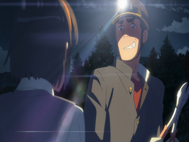

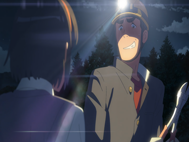

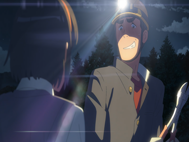

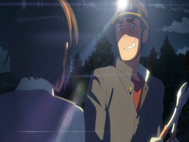

In [112]:
for (x_frame_1, x_frame_2), y_frame in train_yourname_dataloader:
    x_frame_1 = x_frame_1.cuda()
    x_frame_2 = x_frame_2.cuda()
    y_frame = y_frame.cuda()
    break
outputs = model(x_frame_1, x_frame_2)
loss = criterion(outputs, y_frame)
print(loss.item())
display(toPILImage(outputs[0].cpu()))
display(toPILImage(y_frame[0].cpu()))
display(toPILImage(x_frame_1[0].cpu()))
display(toPILImage(x_frame_2[0].cpu()))

In [99]:
training_losses

[0.011968242250639985,
 0.0016320066038798865,
 4940178.576459969,
 0.0025222708602565236,
 0.018661853112275195,
 0.002782557109672214,
 0.0018064311456974893,
 0.001536572367273685,
 0.0014806065784422067,
 0.001426352602262624,
 0.0014325162952186171,
 0.0014335032155478984,
 0.001405680106322547,
 0.0014056442327827932,
 0.0013947215621753762,
 0.0013876707913949252,
 0.0013863143240286163,
 0.0013897327982714564,
 0.0013669477666073463,
 0.0013761513625958185]

In [89]:
val_losses

[0.001630240344365739,
 0.0013479460612812637,
 0.005630107072229235,
 0.0018848978316657503,
 0.0029152773652904884,
 0.002663812881235008,
 0.0015531992225421161,
 0.0012940479857930338,
 0.0016360720918341374,
 0.003324663976652987,
 0.0014099431205002579,
 0.0017104189663399892,
 0.0026128664868096917,
 0.0013476755898758153,
 0.001310175401858368,
 0.001229397182076303,
 0.00126446864645007,
 0.0012706230931865622,
 0.0012255001667263049,
 0.0012511274010021502]

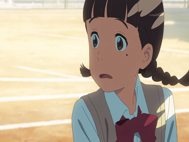

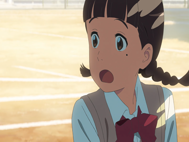

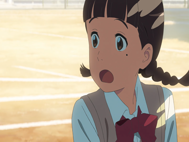

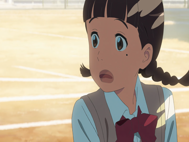

In [94]:
first_img_path = '../../project/data/png/142p/frame_014566.png'
second_img_path = '../../project/data/png/142p/frame_014568.png'
frame_1 = torch.FloatTensor(np.ascontiguousarray(np.array(PIL.Image.open(first_img_path)).transpose(2, 0, 1).astype(np.float32) * (1.0 / 255.0)))
frame_1 = frame_1.view(1,3, frame_1.shape[1], frame_1.shape[2]).cuda()
frame_2 = torch.FloatTensor(np.ascontiguousarray(np.array(PIL.Image.open(second_img_path)).transpose(2, 0, 1).astype(np.float32) * (1.0 / 255.0)))
frame_2 = frame_2.view(1,3, frame_2.shape[1], frame_2.shape[2]).cuda()
target_img_path = '../../project/data/png/142p/frame_014568.png'
frame_3 = torch.FloatTensor(np.ascontiguousarray(np.array(PIL.Image.open(target_img_path)).transpose(2, 0, 1).astype(np.float32) * (1.0 / 255.0)))
frame_3 = frame_3.view(1,3, frame_3.shape[1], frame_3.shape[2]).cuda()
output = model(frame_1, frame_2)
out_img = output[0].cpu()
display(Image(filename=first_img_path))
display(Image(filename=second_img_path))
display(Image(filename=target_img_path))
display(toPILImage(out_img))